# How to training a CNN for MNIST on a cloud GPU

In this notebook, we will train a convolutional neural network on a cloud GPU using the Catalearn module. This saves time for those of us who don't have fast GPUs on our computers.

## Dependencies

#### Normal machine learning dependencies
* tensorflow
* keras
* pandas
* matplotlib
* numpy

#### catalearn
* install with `pip3 install catalearn`

### Load the libraries

In [4]:
from keras.datasets import mnist
from keras.models import load_model
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
% matplotlib inline

Using TensorFlow backend.


## Import and login to Catalearn
In order to use catalearn, an access key is required. 

You can register for an access key at [www.catalern.com](http://catalearn.com).

Replace __ACCESS_KEY__ below with your own key.

In [2]:
import catalearn
catalearn.login(ACCESS_KEY) # replace with your own key

Login successful


## Load the datasets from keras

In [11]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train_reshape = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test_reshape = x_test.reshape(x_test.shape[0], 28, 28, 1)

y_train_onehot = pd.get_dummies(y_train).as_matrix()
y_test_onehot = pd.get_dummies(y_test).as_matrix()

## Upload our training and test sets to catalearn
After we upload the datasets, we can then import them directly on the GPU. This way we don't need to upload the datasets every time we want to train a model.

In [4]:
catalearn.save(x_train_reshape, 'x_train')
catalearn.save(x_test_reshape, 'x_test')
catalearn.save(y_train_onehot, 'y_train')
catalearn.save(y_test_onehot, 'y_test')

Uploading 'x_train'...
Successfully uploaded x_train to the cloud
Uploading 'x_test'...
Successfully uploaded x_test to the cloud
Uploading 'y_train'...
Successfully uploaded y_train to the cloud
Uploading 'y_test'...
Successfully uploaded y_test to the cloud


## Define the function to be run on the GPU

* Use the `catalearn.run_on_gpu` decorator to transform a function into a GPU enabled one.
* Within the function, we need to import `keras` again to use the GPU accelerated version.
* We also import `catalearn` and login again to load the datasets we've just uploaded.
* Don't forget to replace __ACCESS_KEY__ with the key you generated from [www.catalearn.com](http://catalearn.com)

In [65]:
@catalearn.run_on_gpu
def train():

    from keras.models import Sequential
    from keras.layers import Dense, Activation, Conv2D, Flatten, MaxPooling2D
    
    import catalearn
    catalearn.login(ACCESS_KEY) # replace ACCESS_KEY with the key you generated

    x_train = catalearn.load('x_train')
    x_test = catalearn.load('x_test')
    y_train = catalearn.load('y_train')
    y_test = catalearn.load('y_test')

    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3)))
    model.add(Flatten())
    model.add(Activation('relu'))
    model.add(Dense(units=10))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='Adadelta', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=10, batch_size=32)

    loss_and_metrics = model.evaluate(x_test, y_test, batch_size=512)
    print("\n\nTrained model has test accuracy {0}".format(loss_and_metrics[1]))
    
    model.save('mnist_model.h5')

    return loss_and_metrics

## Training the model

Run the decorated `train()` function above to train the model
* The tuple returned by `train()` will also be returned by the decorated function 
* Any files written to the current directory will be available in the local current directory

The model has 0.999 training accuracy and 0.986 test accuracy, which is pretty good : D

In [9]:
metrics = train()
print('validation loss: %s\nvalidation accuracy: %s' % tuple(metrics))
model = load_model('mnist_model.h5')

  0%|          | 0.00/1.15K [00:00<?, ?B/s]

Uploading data


1.46KB [00:00, 4.29KB/s]                   


Job running:
Using TensorFlow backend.
Login successful
Successfully downloaded x_train from the cloud
Successfully downloaded x_test from the cloud
Successfully downloaded y_train from the cloud
Successfully downloaded y_test from the cloud
Epoch 1/10
60000/60000 [==============================] - 20s - loss: 1.2744 - acc: 0.8842    
Epoch 2/10
60000/60000 [==============================] - 16s - loss: 0.0722 - acc: 0.9803    
Epoch 3/10
60000/60000 [==============================] - 16s - loss: 0.0440 - acc: 0.9877    
Epoch 4/10
60000/60000 [==============================] - 15s - loss: 0.0273 - acc: 0.9921    
Epoch 5/10
60000/60000 [==============================] - 15s - loss: 0.0196 - acc: 0.9947    - ETA: 8s 
Epoch 6/10
60000/60000 [==============================] - 15s - loss: 0.0148 - acc: 0.9958    
Epoch 7/10
60000/60000 [==============================] - 15s - loss: 0.0100 - acc: 0.9972    - ETA: 9s - loss: 0.0082 - acc: 0.997 - ETA: 8s - loss: 0.0080 - acc: 0.997 
Epoch 8

1.11MB [00:07, 156KB/s]                             


Done!
New file downloaded: 'mnist_model.h5'
3 minutes used, you have 47 minutes of credit remaining
validation loss: 0.0719804508656
validation accuracy: 0.985900000763


## Lets look at some predictions
Each time you run the cell below a new prediction is shown

I think this is a 5


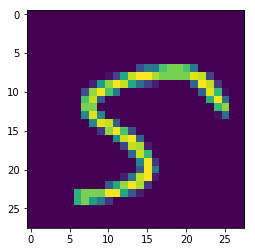

In [64]:
i = np.random.randint(len(x_test))
prediction = np.argmax(model.predict(x_test[i].reshape((1,28,28,1))))

print('I think this is a %s' % prediction)
plt.imshow(x_test[i])
plt.show()